# Simple Example 

In [1]:
from common.ETLBase import PipelineBuilder, PipeConfigBuilder

In [2]:
config = PipeConfigBuilder()

In [3]:
config.setups(a=1,b=2)

In [4]:
pipe = PipelineBuilder(config)
@pipe._func_
def plus_a_b(a=1,b=2):
    return a+b
#pipe._plus_a_b = plus_a_b

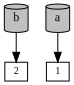

In [5]:
pipe.view(summary=False)

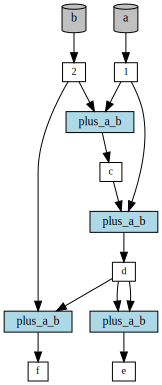

In [6]:
pipe.setup_connection('c = plus_a_b(a=a,b=b)')
pipe.setup_connection('d = plus_a_b(a=a,b=c)')
pipe.setup_connection('e = plus_a_b(d,d)')
pipe.setup_connection('f = plus_a_b(a=b,b=d)')

pipe.view(summary=False)

In [7]:
pipe.f.get()

6

# Build Pipeline 

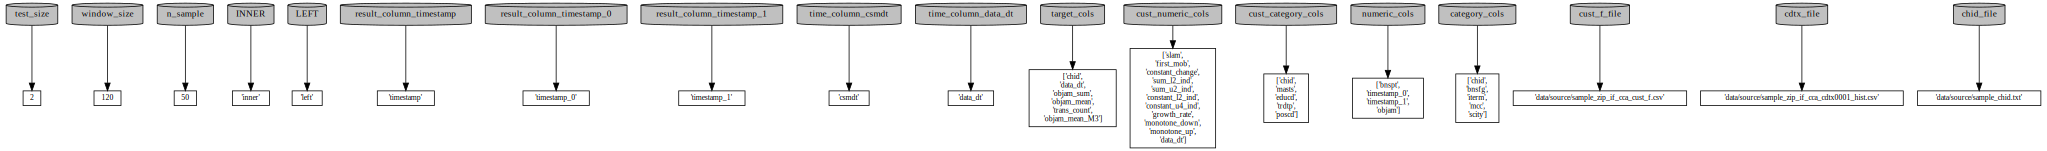

In [8]:
# from experiments.ex3.preprocess_modules import *
from experiments.ex3.preprocess_modules import GenerateSparseDenseSetting
from common.ETLBase import PipelineBuilder, PipeConfigBuilder
import os
origin_path = 'data/source'
sample_path = 'data/sample'

tmp_path = 'data/tmp' # 'data/tmp'
result_path = 'data/result' # 'data/result'


CATEGORY_COLS = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity']
NUMERIC_COLS = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']

config = PipeConfigBuilder()

config.setups(
    chid_file=os.path.join(origin_path, 'sample_chid.txt'),
    cdtx_file=os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv'),
    cust_f_file=os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv'),
    category_cols=CATEGORY_COLS,
    numeric_cols=NUMERIC_COLS,
    cust_category_cols=['chid', 'masts', 'educd', 'trdtp', 'poscd'],
    cust_numeric_cols=['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt'],
    target_cols=['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3'],
    time_column_data_dt='data_dt',
    time_column_csmdt='csmdt',
    result_column_timestamp_1='timestamp_1',
    result_column_timestamp_0='timestamp_0',
    result_column_timestamp='timestamp',
    LEFT='left',
    INNER='inner',
    n_sample=50,
    window_size=120,
    test_size=2
)

sparse_feat = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity']
dense_feat = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']
USE_CHID = True

sparse_dense_setting_generator = GenerateSparseDenseSetting(
    category_cols=CATEGORY_COLS, 
    sparse_feat=sparse_feat, 
    numeric_cols=NUMERIC_COLS, 
    dense_feat=dense_feat, 
    USE_CHID=USE_CHID
)
config.view(summary=False)

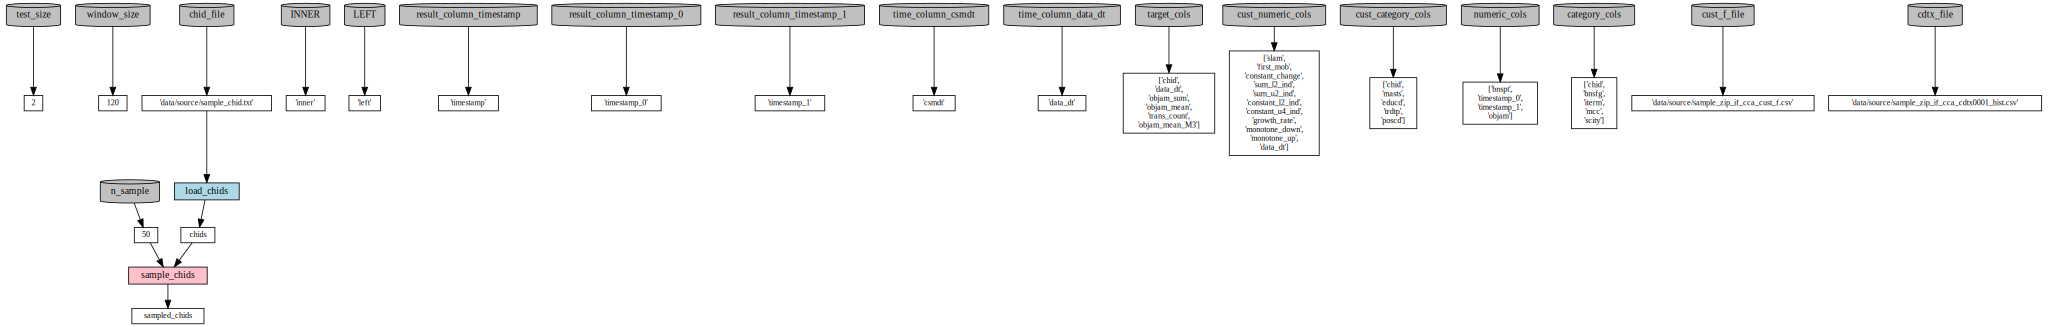

In [9]:
pipe = PipelineBuilder(config, func_source='experiments.ex3.preprocess_modules')

pipe.setup_connection('chids = load_chids(chid_file=chid_file)')

pipe.setup_connection('sampled_chids = sample_chids(chids, n_sample = n_sample)', 
                      result_dir = os.path.join(sample_path,'sampled_chids.npy'))
pipe.view(summary = False)

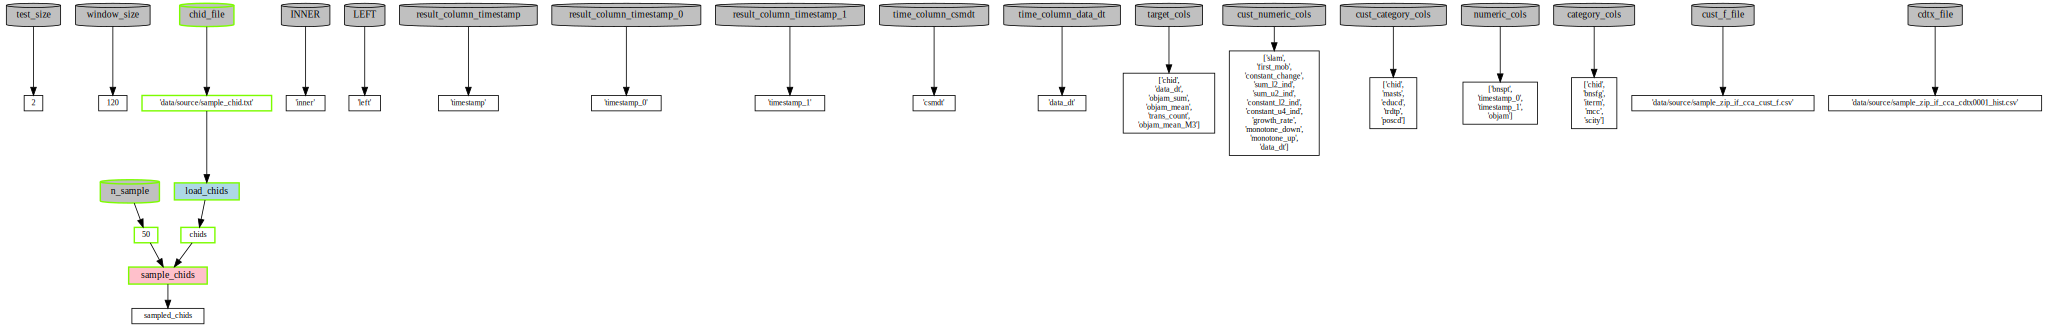

In [10]:
pipe.view_dependency('sample_chids', summary=False)

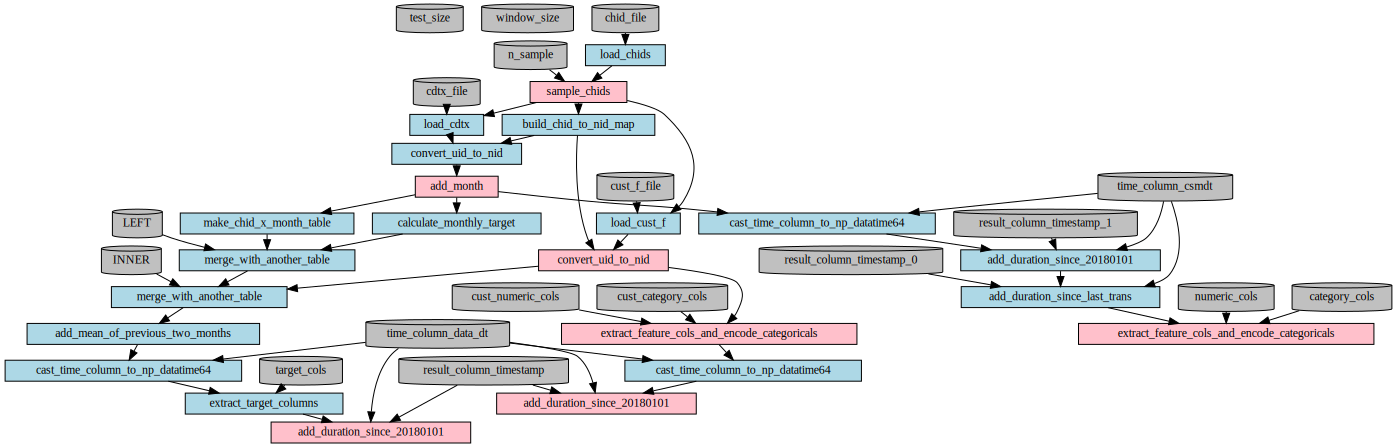

In [11]:

pipe.setup_connection('chid_to_nid_map = build_chid_to_nid_map(sampled_chids)')

pipe.setup_connection('df_cdtx = load_cdtx(sampled_chids, cdtx_file = cdtx_file)')

pipe.setup_connection('df_cdtx = convert_uid_to_nid(df_cdtx, chid_to_nid_map)')

pipe.setup_connection('df_cdtx = add_month(df_cdtx)',
                      result_dir = os.path.join(tmp_path, 'df_cdtx.feather')
                     )

pipe.setup_connection('df_full_y_sum = make_chid_x_month_table(df_cdtx)')

pipe.setup_connection('df_cdtx_monthly_objam = calculate_monthly_target(df_cdtx)')

pipe.setup_connection('df_full_y_sum = merge_with_another_table(df_full_y_sum, df_cdtx_monthly_objam, join_method=LEFT)')

pipe.setup_connection('df_cust_f = load_cust_f(sampled_chids, cust_f_file=cust_f_file)')

pipe.setup_connection('df_cust_f = convert_uid_to_nid(df_cust_f, chid_to_nid_map)',
                      result_dir = os.path.join(tmp_path, 'df_cust_f.feather')
                     )

pipe.setup_connection('df_full_y_sum = merge_with_another_table(df_full_y_sum, df_cust_f, join_method=INNER)')

pipe.setup_connection('df_full_y_sum = add_mean_of_previous_two_months(df_full_y_sum)')

pipe.setup_connection('df_full_y_sum = cast_time_column_to_np_datatime64(df_full_y_sum, time_column = time_column_data_dt)')

pipe.setup_connection('df_cdtx = cast_time_column_to_np_datatime64(df_cdtx, time_column = time_column_csmdt)')

pipe.setup_connection('df_cdtx = add_duration_since_20180101(df_cdtx, time_column = time_column_csmdt, result_column=result_column_timestamp_1)')

pipe.setup_connection('df_cdtx = add_duration_since_last_trans(df_cdtx, time_column = time_column_csmdt, result_column=result_column_timestamp_0)')

pipe.setup_connection(
    'df_input, feature_map = extract_feature_cols_and_encode_categoricals(df_cdtx, numeric_cols=numeric_cols, category_cols=category_cols)',
    result_dir=[
                os.path.join(tmp_path, 'df_input.feather'),
                os.path.join(tmp_path, 'feature_map.npy')
            ]
)

pipe.setup_connection(
    'df_feat_input, cust_feature_map = '
    'extract_feature_cols_and_encode_categoricals('
    'df_cust_f, numeric_cols=cust_numeric_cols, category_cols=cust_category_cols'
    ')',
    result_dir=[
                os.path.join(tmp_path, 'df_feat_input.feather'),
                os.path.join(tmp_path, 'cust_feature_map.npy')
            ]
)

pipe.setup_connection(
    'df_feat_input = '
    'cast_time_column_to_np_datatime64('
        'df_feat_input, time_column = time_column_data_dt'
    ')'
)

pipe.setup_connection(
    'df_feat_input = '
    'add_duration_since_20180101('
        'df_feat_input, time_column = time_column_data_dt, result_column=result_column_timestamp'
    ')',
    result_dir = os.path.join(tmp_path, 'df_feat_input.2.feather')
)

pipe.setup_connection(
    'df_y = '
    'extract_target_columns('
        'df_full_y_sum, target_cols=target_cols'
    ')'
)

pipe.setup_connection(
    'df_y = '
    'add_duration_since_20180101('
        'df_y, time_column = time_column_data_dt, result_column=result_column_timestamp'
    ')',
    result_dir = os.path.join(tmp_path, 'df_y.feather')
)

pipe.view(summary=True, gap=0.1)

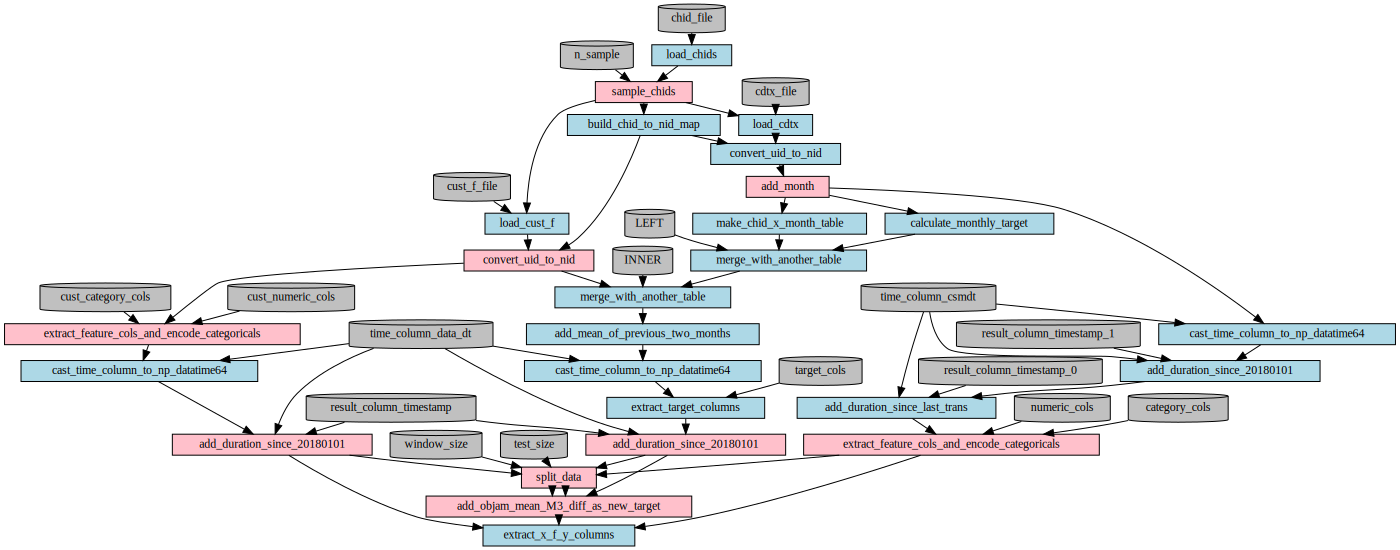

In [12]:

pipe.setup_connection(
    'x_train, x_test, f_train, f_test, y_train, y_test = '
    'split_data('
        'df_input, df_feat_input, df_y, window_size = window_size, test_size = test_size'
    ')',
    result_dir=[
                os.path.join(tmp_path, 'x_train.npy'),
                os.path.join(tmp_path, 'x_test.npy'),
                os.path.join(tmp_path, 'f_train.npy'),
                os.path.join(tmp_path, 'f_test.npy'),
                os.path.join(tmp_path, 'y_train.npy'),
                os.path.join(tmp_path, 'y_test.npy')
            ]
)

pipe.setup_connection(
    'y_train, y_test, y_columns = '
    'add_objam_mean_M3_diff_as_new_target('
        'df_y, y_train, y_test'
    ')',
    result_dir=[
        os.path.join(tmp_path, 'y_train.npy'),
        os.path.join(tmp_path, 'y_test.npy'),
        os.path.join(tmp_path, 'y_columns.npy')
    ]
)

pipe.setup_connection(
    'columns = '
    'extract_x_f_y_columns('
        'df_input, df_feat_input, y_columns'
    ')'
)

pipe.view(summary=True, gap=0.1)

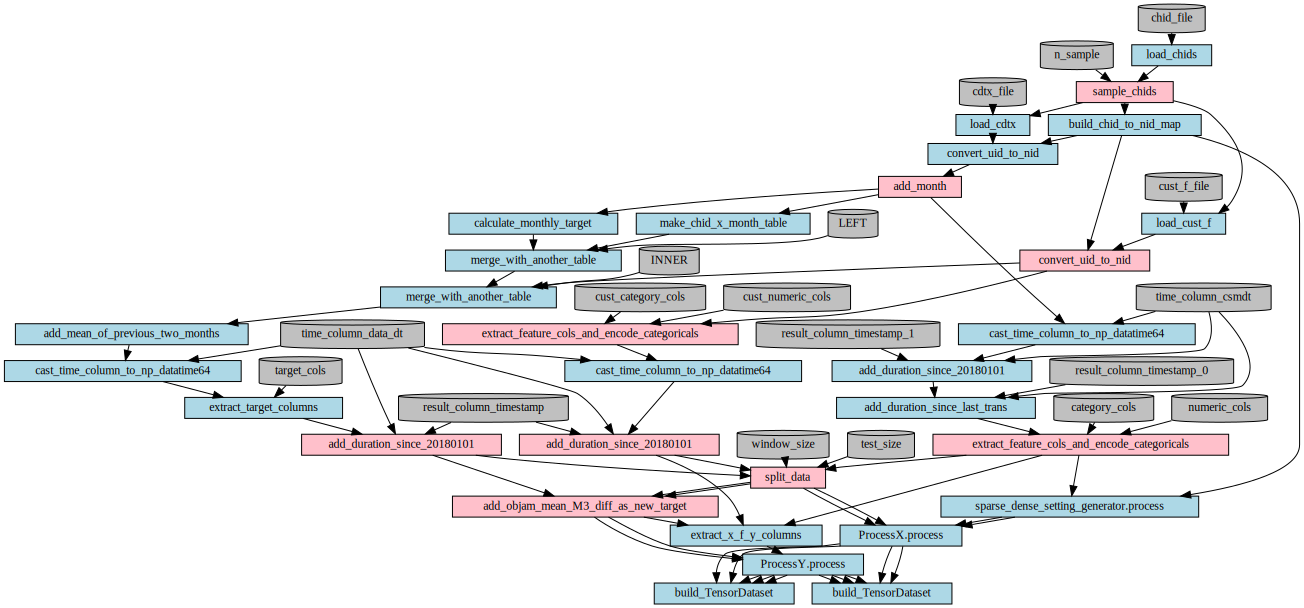

In [13]:
pipe.setup_connection(
    'sparse_dims, sparse_index, dense_dims, dense_index = '
    'sparse_dense_setting_generator.process('
        'feature_map, chid_to_nid_map'
    ')',
    func = sparse_dense_setting_generator.process
)

from experiments.ex3.preprocess_modules import ProcessX, ProcessY

pipe.setup_connection(
    'x_train_sparse, x_train_dense, x_test_sparse, x_test_dense = '
    'ProcessX.process('
        'x_train, x_test, sparse_index, dense_index'
    ')',
    func = ProcessX.process
)

pipe.setup_connection(
    'train_objmean, train_tscnt, train_label_0, test_objmean, test_tscnt, test_label_0 = '
    'ProcessY.process('
        'y_train, y_test, columns'
    ')',
    func = ProcessY.process
)

pipe.setup_connection(
    'train_dataset = '
    'build_TensorDataset('
        'x_train_dense, x_train_sparse, train_objmean, train_tscnt, train_label_0'
    ')'
)
    
pipe.setup_connection(
    'test_dataset = '
    'build_TensorDataset('
        'x_test_dense, x_test_sparse, test_objmean, test_tscnt, test_label_0'
    ')'
)
    
pipe.view(summary=True, gap = 0.1)

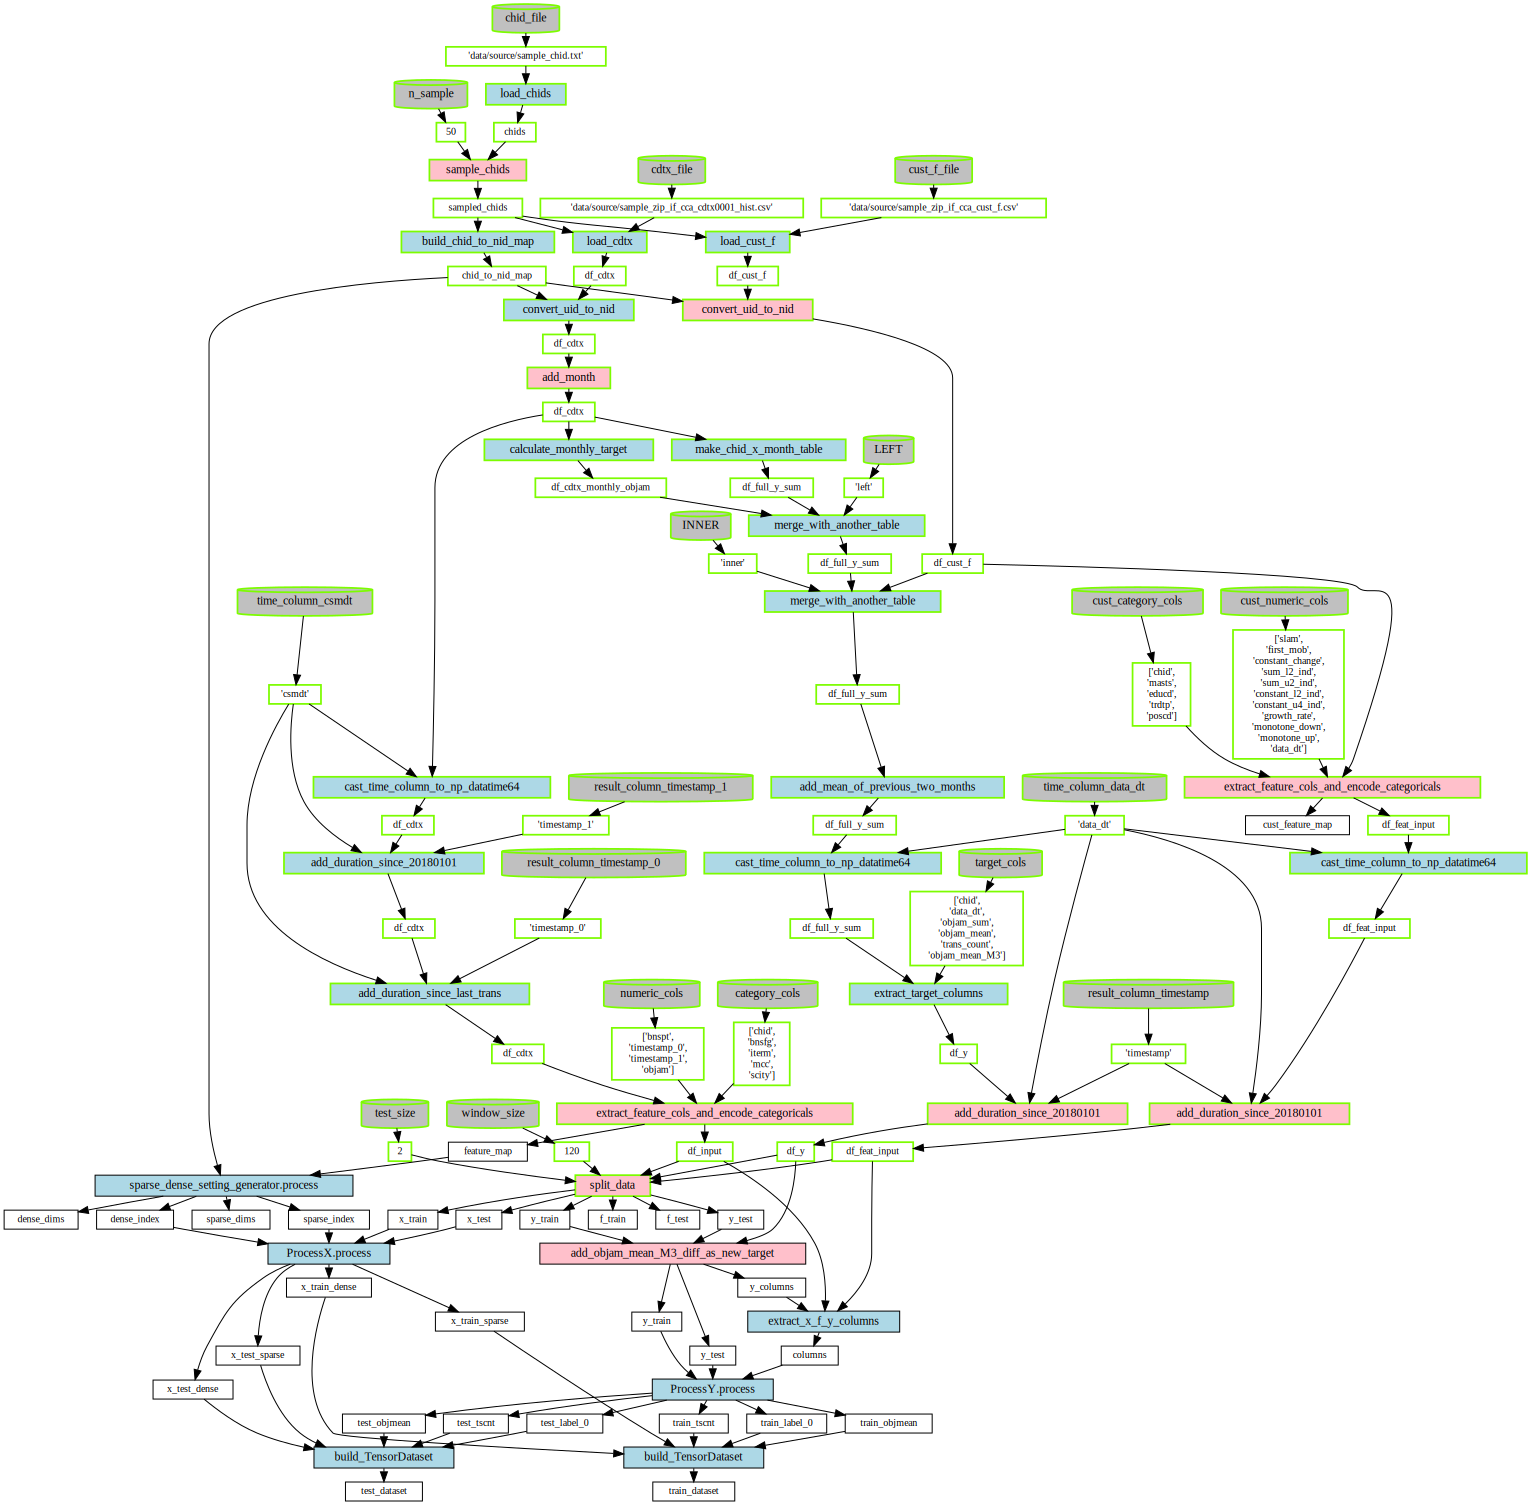

In [14]:
pipe.view_dependency('split_data', summary=False, gap = 0.2)

In [16]:
pipe.test_dataset.get(verbose=True)

[RUN] process of "process[3]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[2]"
Processing x_train
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
Processing x_test
Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively
apply Log(1+x) transformation to the dense features
apply MinMaxScale((0,1)) to the dense features
[RUN] process of "process[3]"
Convert Numeric Y values to np.float64 for Regression
Apply Log(1+x) Transformation
Apply  MinMaxScaler((0,1)) to objmean
Convert ob